# COCO Dataset Splitter

In [21]:
import json
import os
import random
import shutil

import copy

from collections import defaultdict
from typing import List, Set, Dict, Optional, Any, Tuple

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

import cv2

import numpy as np

# import albumentations as A
from tqdm import tqdm

In [24]:


def split_coco_dataset(coco_file_name, images_dir, output_dir, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    """
    Splits a COCO dataset (with separate annotations and images folders) into training, validation, and testing groups.

    Args:
        coco_file_name (str): Path to the annotations directory containing annotations.
        images_dir (str): Path to the images directory containing the PNG images.
        output_dir (str): Path to the output directory where the split datasets will be saved.
        train_ratio (float): Ratio of images for the training set.
        val_ratio (float): Ratio of images for the validation set.
        test_ratio (float): Ratio of images for the testing set.
    """
    
    # Ensure output_dir exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # coco_json = os.path.join(annotations_dir, coco_file_name)

    with open(coco_file_name, 'r') as f:
        coco_data = json.load(f)

    # Separate images and annotations form coco file
    coco_images = coco_data['images']
    all_annotations = coco_data['annotations']

    # Shuffle coco images list to randomize the split
    random.shuffle(coco_images)  

    num_images = len(coco_images)
    num_train = int(num_images * train_ratio)
    num_val = int(num_images * val_ratio)
    num_test = int(num_images * test_ratio)

    print(f"Images total: {num_images}")
    print(f"Images num_train: {num_train}")
    print(f"Images num_val: {num_val}")
    print(f"Images num_test: {num_test}")

    # Create the image list splits
    train_coco_image_list = coco_images[:num_train]
    val_coco_image_list = coco_images[num_train:num_train + num_val]
    test_coco_image_list = coco_images[num_train + num_val:]

    def create_split_data(coco_image_list, split_name):
        
        split_images = [img['id'] for img in coco_image_list]
        
        split_annotations = [ann for ann in all_annotations if ann['image_id'] in split_images]
        
        # Create new coco file with split data
        split_data = {
            'info': coco_data.get('info', {}),
            'licenses': coco_data.get('licenses', []),
            'categories': coco_data['categories'],
            'images': coco_image_list,
            'annotations': split_annotations,
        }

        split_dir = os.path.join(output_dir, split_name)
        # Ensure split_dir exists
        if not os.path.exists(split_dir):
            os.makedirs(split_dir)

        output_json = os.path.join(split_dir, f'coco_{split_name}.json')
        
        # Check if JSON file already exists
        if not os.path.exists(output_json):
            with open(output_json, 'w') as f:
                json.dump(split_data, f)
            print(f"Created {output_json}")
        else:
            print(f"JSON file already exists: {output_json}")

        # Save images into separate directories
        images_output_dir = os.path.join(output_dir, split_name, "images")
        if not os.path.exists(images_output_dir):
            os.makedirs(images_output_dir)

        for img in coco_image_list:
            source_path = os.path.join(images_dir, img['file_name'])
            dest_path = os.path.join(images_output_dir, img['file_name'])
            try:
                shutil.copy(source_path, dest_path)
            except FileNotFoundError:
                print(f"Warning: Image file not found: {source_path}")


    create_split_data(train_coco_image_list, 'train')
    create_split_data(val_coco_image_list, 'val')
    create_split_data(test_coco_image_list, 'test')


def plot_coco_images(output_dir):
    """Plots 5 random images with bounding boxes from each split (train, val, test)."""

    split_names = ['train', 'val', 'test']
    random.seed(42) #for reproducibility.

    for split_name in split_names:
        split_dir = os.path.join(output_dir, split_name)
        json_path = os.path.join(split_dir, f'coco_{split_name}.json')

        with open(json_path, 'r') as f:
            coco_data = json.load(f)

        images = coco_data['images']
        annotations = coco_data['annotations']
        categories = coco_data['categories']

        category_map = {cat['id']: cat['name'] for cat in categories}
        image_ids = [img['id'] for img in images]

        random_image_ids = random.sample(image_ids, min(5, len(image_ids))) #avoid error if less than 5 images.

        for image_id in random_image_ids:
            image_info = next(img for img in images if img['id'] == image_id)
            image_path = os.path.join(split_dir, 'images', image_info['file_name'])
            image = Image.open(image_path)

            fig, ax = plt.subplots(1)
            ax.imshow(image)

            image_annotations = [ann for ann in annotations if ann['image_id'] == image_id]

            category_colors = {}
            for ann in image_annotations:
                category_id = ann['category_id']
                if category_id not in category_colors:
                    category_colors[category_id] = (random.random(), random.random(), random.random()) #assign unique color.

                color = category_colors[category_id]
                x, y, w, h = ann['bbox']
                rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor=color, facecolor='none')
                ax.add_patch(rect)

                category_name = category_map[category_id]
                ax.text(x, y, category_name, color=color, fontsize=8, verticalalignment='top', horizontalalignment='left', bbox=dict(facecolor='white', alpha=0.5))

            plt.title(f"{split_name} - Image ID: {image_id}")
            plt.show()

def plot_single_coco_image(image_path, coco_json_path):
    """
    Plots a single COCO image with bounding boxes and category labels.

    Args:
        image_path (str): Path to the image file.
        coco_json_path (str): Path to the COCO JSON annotation file.
    """

    with open(coco_json_path, 'r') as f:
        coco_data = json.load(f)

    images = coco_data['images']
    annotations = coco_data['annotations']
    categories = coco_data['categories']

    category_map = {cat['id']: cat['name'] for cat in categories}

    image_filename = os.path.basename(image_path)
    image_info = next((img for img in images if img['file_name'] == image_filename), None)

    if image_info is None:
        print(f"Image '{image_filename}' not found in COCO annotations.")
        return

    image_id = image_info['id']
    image = Image.open(image_path)

    fig, ax = plt.subplots(1)
    ax.imshow(image)

    image_annotations = [ann for ann in annotations if ann['image_id'] == image_id]

    category_colors = {}
    for ann in image_annotations:
        category_id = ann['category_id']
        if category_id not in category_colors:
            category_colors[category_id] = (random.random(), random.random(), random.random())

        color = category_colors[category_id]
        x, y, w, h = ann['bbox']
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)

        category_name = category_map[category_id]
        ax.text(x, y, category_name, color=color, fontsize=8, verticalalignment='top', horizontalalignment='left', bbox=dict(facecolor='white', alpha=0.5))

    plt.title(f"Image: {image_filename}")
    plt.show()


def populate_empty_segmentation_annotation(ann):
    """
    Populates an empty segmentation list in a COCO annotation with a bounding box polygon.

    Args:
        ann (dict): A COCO annotation dictionary.

    Returns:
        list: A list representing the bounding box polygon, or None if population fails.
    """

    if 'bbox' in ann and 'image_id' in ann:
        x, y, w, h = ann['bbox']
        polygon = [x, y, x + w, y, x + w, y + h, x, y + h]  # Bounding box polygon
        return [polygon]  # Populate with polygon
    else:
        print(f"Warning: Annotation {ann['id']} has empty segmentation but is missing bbox or image_id.")
        return None  # Indicate population failure
        
        
def validate_coco_data(annotations_directory, coco_file, images_directory, output_coco_file=None):
    """
    Validates a COCO annotation file for well-formed segmentation data,
    missing bounding boxes, and missing categories. Optionally populates empty segmentation and returns a new COCO data dictionary.

    Args:
        annotations_directory (str): Path to the annotations directory.
        coco_file (str): Name of the COCO annotation file.
        images_directory (str): Path to the images directory.
        output_coco_file (str, optional): If provided, the validated and populated COCO data will be saved to this file.
                                          If None, the original COCO data dictionary will be modified and returned.

    Returns:
        dict: A dictionary containing the validated COCO data.
              Returns None if there are critical errors that prevent further processing.
    """

    coco_path = os.path.join(annotations_directory, coco_file)

    try:
        with open(coco_path, 'r') as f:
            coco_data = json.load(f)
    except FileNotFoundError:
        print(f"Error: COCO annotation file not found at {coco_path}")
        return None
    except json.JSONDecodeError:
        print(f"Error: Invalid JSON format in {coco_path}")
        return None

    images = coco_data['images']
    annotations = coco_data['annotations']
    categories = coco_data['categories']

    category_ids = {cat['id'] for cat in categories}
    image_ids = {img['id'] for img in images}

    errors_found = False
    modified = False  # Track if any changes were made

    # Create a copy of the COCO data to modify
    validated_coco_data = copy.deepcopy(coco_data)
    validated_annotations = validated_coco_data['annotations']

    # Check for segmentation issues
    for i, ann in enumerate(validated_annotations):
        if 'segmentation' not in ann:
            print(f"Error: Annotation {ann['id']} missing segmentation data.")
            errors_found = True
        elif not ann['segmentation']:  # Check for empty segmentation lists
            print(f"Warning: Annotation {ann['id']} has empty segmentation list. Attempting to populate.")
            populated_segmentation = populate_empty_segmentation_annotation(ann)
            if populated_segmentation:
                validated_annotations[i]['segmentation'] = populated_segmentation
                modified = True
            else:
                print(f"Error: Annotation {ann['id']} still has empty segmentation list after population attempt.")
                errors_found = True
        elif isinstance(ann['segmentation'], list) and not all(isinstance(seg, (int, float)) for sublist in ann['segmentation'] for seg in sublist if isinstance(ann['segmentation'], list) and ann['segmentation']):  # check if segmentation is a list, and if it contains only numbers.
            print(f"Error: Annotation {ann['id']} has malformed segmentation data.")
            errors_found = True

    # Check for missing bounding boxes and categories
    for ann in validated_annotations:
        if 'bbox' not in ann:
            print(f"Error: Annotation {ann['id']} missing bounding box data.")
            errors_found = True
        if 'category_id' not in ann or ann['category_id'] not in category_ids:
            print(f"Error: Annotation {ann['id']} has invalid or missing category ID.")
            errors_found = True

    # Check for images with missing annotations
    annotated_image_ids = {ann['image_id'] for ann in validated_annotations}
    for img in validated_coco_data['images']:
        if img['id'] not in annotated_image_ids:
            print(f"Warning: Image {img['file_name']} has no annotations.")

    # Check for images that cannot be opened.
    for img in validated_coco_data['images']:
        image_path = os.path.join(images_directory, img['file_name'])
        try:
            Image.open(image_path)
        except FileNotFoundError:
            print(f"Error: image file not found: {image_path}")
            errors_found = True
        except Exception as e:
            print(f"Error: could not open image {image_path}. Error: {e}")
            errors_found = True

    if not errors_found:
        print("COCO annotation data validation successful.")
    else:
        print("Errors found in COCO annotation data.")

    if modified:
        print("Segmentation data was modified.")

    if output_coco_file:
        try:
            with open(output_coco_file, 'w') as f:
                json.dump(validated_coco_data, f, indent=2)  # Save modified JSON to new file
            print(f"Validated COCO data saved to: {output_coco_file}")
        except IOError:
            print(f"Error: Could not write to {output_coco_file}")
            return None  # Return None if saving fails

    return validated_coco_data



def analyze_coco_annotations(coco_file: str):
    """
    Reads a COCO JSON annotation file and returns the number of classes
    and the count of instances for each class.

    Args:
        annotation_file_path: The path to the COCO JSON annotation file.

    Returns:
        A tuple containing:
            - The total number of unique classes (int).
            - A dictionary where keys are class names (str) and values are
              the number of instances (annotations) for that class (int).
        Returns None if the file cannot be read or parsed, or if the
        required keys ('categories', 'annotations') are missing.
    """
    
    if not os.path.exists(coco_file):
        print(f"Error: File not found at '{coco_file}'")
        return None

    try:
        with open(coco_file, 'r') as f:
            data: Dict[str, Any] = json.load(f)
    except json.JSONDecodeError:
        print(f"Error: Could not decode JSON from '{coco_file}'")
        return None
    except Exception as e:
        print(f"Error reading file '{coco_file}': {e}")
        return None


    # Check for essential COCO keys
    if 'categories' not in data:
        print("Error: 'categories' key not found in the JSON file.")
        return None
    if 'annotations' not in data:
        print("Error: 'annotations' key not found in the JSON file.")
        return None

    # --- Get Number of Classes ---
    categories = data.get('categories', [])
    
    # Create a mapping from category ID to category name for easier lookup
    category_id_to_name: Dict[int, str] = {
        cat['id']: cat.get('name', f"Unnamed_ID_{cat['id']}")
        for cat in categories
    }
    
    
    # --- Count Instances Per Class ---
    cat_instances: Dict[int, int] = defaultdict(int)
    annotations = data.get('annotations', [])
    
    for ann in annotations:
        cat_id = ann.get('category_id')
        if cat_id is not None:
            cat_instances[cat_id] += 1
        else:
            print(f"Annotation: {ann.get('id', 'N/A')} has no'category_id'")
    

    
    # Convert counts from category ID keys to category name keys
    instance_counts_by_name: Dict[str, int] = {}
    for cat_id, count in cat_instances.items():
        class_name = category_id_to_name.get(cat_id, f"Unknown_ID_{cat_id}")
        instance_counts_by_name[class_name] = count

    # Include classes defined in 'categories' but having zero annotations
    for cat_id, cat_name in category_id_to_name.items():
        if cat_name not in instance_counts_by_name:
            instance_counts_by_name[cat_name] = 0
    
    return category_id_to_name, instance_counts_by_name
    
    
    

def filter_coco_dataset_reindex(
    coco_file: str,
    images_path: str,
    target_classes: List[str],
    num_class_instances: int,
    output_directory: str,
    start_category_id: int = 1 # Option to start indexing from a different number
) -> Optional[str]:
    """
    Filters a COCO dataset based on target classes and instance limits,
    re-indexes the category IDs sequentially, updates annotations accordingly,
    and copies relevant images to a new directory structure.

    Args:
        coco_file: Path to the input COCO JSON annotation file.
        images_path: Path to the folder containing all original images.
        target_classes: A list of class names (str) to include in the output.
        num_class_instances: The maximum number of instances (annotations)
                             to include for EACH target class.
        output_directory: The base path where the new filtered dataset
                          (annotations file and images folder) will be created.
                          Subfolders 'annotations' and 'images' will be created here.
        start_category_id: The starting ID for the re-indexed categories (default: 1).

    Returns:
        The path to the newly created filtered COCO JSON file, or None if
        an error occurred.
    """
    print(f"Starting COCO dataset filtering with re-indexing...")
    print(f"  Input COCO file: {coco_file}")
    print(f"  Input Images path: {images_path}")
    print(f"  Target classes: {target_classes}")
    print(f"  Max instances per class: {num_class_instances}")
    print(f"  Output directory: {output_directory}")
    print(f"  Starting new category ID from: {start_category_id}")


    # --- Input Validation ---
    if not os.path.isfile(coco_file):
        print(f"Error: Input COCO file not found at '{coco_file}'")
        return None
    if not os.path.isdir(images_path):
        print(f"Error: Input images directory not found at '{images_path}'")
        return None
    if not isinstance(target_classes, list) or not all(isinstance(c, str) for c in target_classes):
        print(f"Error: target_classes must be a list of strings.")
        return None
    if not isinstance(num_class_instances, int) or num_class_instances <= 0:
        print(f"Error: num_class_instances must be a positive integer.")
        return None
    if not output_directory:
         print(f"Error: Output directory path cannot be empty.")
         return None
    if not isinstance(start_category_id, int) or start_category_id < 0:
         print(f"Error: start_category_id must be a non-negative integer.")
         return None


    target_classes_set = set(target_classes) # Use set for faster lookups

    # --- Load Input COCO Data ---
    try:
        with open(coco_file, 'r') as f:
            coco_data: Dict[str, Any] = json.load(f)
        print(f"Successfully loaded input COCO file.")
    except json.JSONDecodeError:
        print(f"Error: Could not decode JSON from '{coco_file}'")
        return None
    except Exception as e:
        print(f"Error reading file '{coco_file}': {e}")
        return None

    # Check for essential COCO keys
    if 'categories' not in coco_data or 'annotations' not in coco_data or 'images' not in coco_data:
        print("Error: Input COCO file missing essential keys ('categories', 'annotations', 'images').")
        return None

    # --- Identify Target Categories & Prepare for Re-indexing ---
    print("Identifying and preparing categories for re-indexing...")
    original_categories = coco_data.get('categories', [])
    kept_original_categories: List[Dict[str, Any]] = [] # Store the original dicts of categories we want to keep

    original_target_ids = set() # Store original IDs of the classes we are keeping
    found_target_classes = set()

    for cat in original_categories:
        cat_name = cat.get('name')
        cat_id = cat.get('id')
        if cat_name and cat_id is not None and cat_name in target_classes_set:
             if cat_id not in original_target_ids: # Avoid duplicates if input has them
                 kept_original_categories.append(cat)
                 original_target_ids.add(cat_id)
                 found_target_classes.add(cat_name)
                 print(f"  Identified target category: '{cat_name}' (Original ID: {cat_id})")
             else:
                 print(f"  Warning: Duplicate category ID {cat_id} found for target name '{cat_name}' in input. Using first occurrence.")

    missing_target_classes = target_classes_set - found_target_classes
    if missing_target_classes:
        print(f"  Warning: The following target classes were not found in the input file: {missing_target_classes}")
    if not kept_original_categories:
        print("Error: None of the specified target classes were found in the input COCO file's categories.")
        return None

    # Sort kept categories for consistent re-indexing (e.g., by name)
    kept_original_categories.sort(key=lambda x: x.get('name', ''))

    # Create mapping from original ID to new ID and build new categories list
    original_id_to_new_id: Dict[int, int] = {}
    new_categories: List[Dict[str, Any]] = []
    current_new_id = start_category_id

    print("Assigning new category IDs...")
    for cat_original in kept_original_categories:
        original_id = cat_original['id']
        new_id = current_new_id
        original_id_to_new_id[original_id] = new_id

        # Create a copy and update the ID
        cat_new = cat_original.copy()
        cat_new['id'] = new_id
        new_categories.append(cat_new)

        print(f"  Mapping: '{cat_new.get('name')}' (Original ID: {original_id}) -> New ID: {new_id}")
        current_new_id += 1


    # --- Filter Annotations & Update Category IDs ---
    print("Filtering annotations and updating category IDs...")
    original_annotations = coco_data.get('annotations', [])
    new_annotations: List[Dict[str, Any]] = []
    instance_counter: Dict[int, int] = defaultdict(int) # Count based on ORIGINAL category ID
    images_to_keep_ids: Set[int] = set() # Store IDs of images with kept annotations

    for ann_original in original_annotations:
        original_category_id = ann_original.get('category_id')
        image_id = ann_original.get('image_id')

        if original_category_id is not None and image_id is not None:
            # Check if annotation belongs to a target class (using original ID)
            if original_category_id in original_target_ids:
                # Check if we haven't exceeded the instance limit for this class
                if instance_counter[original_category_id] < num_class_instances:
                    # Get the NEW category ID
                    new_category_id = original_id_to_new_id[original_category_id]

                    # Create a copy and update the category_id
                    ann_new = ann_original.copy()
                    ann_new['category_id'] = new_category_id

                    new_annotations.append(ann_new)
                    instance_counter[original_category_id] += 1 # Increment counter for the original ID
                    images_to_keep_ids.add(image_id)

    print(f"  Kept {len(new_annotations)} annotations matching criteria.")
    # Log counts based on original categories for clarity during filtering
    for cat_original in kept_original_categories:
         orig_id = cat_original['id']
         cat_name = cat_original.get('name', f"Unknown Original ID {orig_id}")
         print(f"    - Class '{cat_name}' (Original ID: {orig_id}): {instance_counter[orig_id]} instances kept")


    if not new_annotations:
        print("Warning: No annotations matched the filtering criteria. The output file will be generated but contain no annotations.")

    # --- Filter Images (No change needed here) ---
    print("Filtering image list...")
    original_images = coco_data.get('images', [])
    new_images: List[Dict[str, Any]] = []
    original_image_id_map: Dict[int, Dict[str, Any]] = {img['id']: img for img in original_images if 'id' in img}

    kept_image_filenames: Set[str] = set()
    for img_id in images_to_keep_ids:
        if img_id in original_image_id_map:
            img_dict = original_image_id_map[img_id]
            new_images.append(img_dict) # Keep original image dict
            if 'file_name' in img_dict:
                kept_image_filenames.add(img_dict['file_name'])
            else:
                print(f"  Warning: Image dictionary for ID {img_id} has no 'file_name' key.")
        else:
            print(f"  Warning: Image ID {img_id} referenced in kept annotations, but not found in the original image list.")

    print(f"  Kept {len(new_images)} image entries corresponding to kept annotations.")

    # --- Construct New COCO Data ---
    new_coco_data: Dict[str, Any] = {}
    # Copy optional top-level keys if they exist
    for key in ['info', 'licenses']:
        if key in coco_data:
            new_coco_data[key] = coco_data[key]

    # Add the filtered and re-indexed lists
    new_coco_data['images'] = new_images
    new_coco_data['annotations'] = new_annotations
    new_coco_data['categories'] = new_categories # This now has re-indexed IDs

    # --- Create Output Directories ---
    output_annotations_dir = os.path.join(output_directory, 'annotations')
    output_images_dir = os.path.join(output_directory, 'images')

    try:
        print(f"Creating output directories...")
        os.makedirs(output_annotations_dir, exist_ok=True)
        os.makedirs(output_images_dir, exist_ok=True)
        print(f"  Created/Ensured directory: {output_annotations_dir}")
        print(f"  Created/Ensured directory: {output_images_dir}")
    except OSError as e:
        print(f"Error: Could not create output directories in '{output_directory}': {e}")
        return None

    # --- Save Filtered COCO JSON ---
    output_coco_file_name = f"new_{os.path.basename(coco_file)}"
    # Ensure it has a .json extension
    if not output_coco_file_name.lower().endswith('.json'):
         base, _ = os.path.splitext(output_coco_file_name)
         output_coco_file_name = base + '.json'

    output_coco_path = os.path.join(output_annotations_dir, output_coco_file_name)

    try:
        print(f"Saving filtered and re-indexed COCO JSON to: {output_coco_path}")
        with open(output_coco_path, 'w') as f:
            json.dump(new_coco_data, f, indent=4) # Use indent for readability
        print(f"Successfully saved filtered annotations.")
    except Exception as e:
        print(f"Error writing filtered COCO JSON to '{output_coco_path}': {e}")
        return None

    # --- Copy Relevant Image Files (No change needed here) ---
    print(f"Copying relevant images from '{images_path}' to '{output_images_dir}'...")
    copied_count = 0
    skipped_count = 0
    error_count = 0

    for filename in kept_image_filenames:
        source_img_path = os.path.join(images_path, filename)
        dest_img_path = os.path.join(output_images_dir, filename)

        if not os.path.isfile(source_img_path):
            print(f"  Warning: Source image file not found, skipping copy: {source_img_path}")
            skipped_count += 1
            continue

        try:
            shutil.copy2(source_img_path, dest_img_path)
            copied_count += 1
        except Exception as e:
            print(f"  Error copying image '{filename}' from '{source_img_path}' to '{dest_img_path}': {e}")
            error_count += 1

    print(f"Image copying finished:")
    print(f"  Successfully copied: {copied_count}")
    print(f"  Skipped (source not found): {skipped_count}")
    print(f"  Errors during copy: {error_count}")

    print(f"\nFiltering and re-indexing process complete. Output written to: {output_directory}")
    return output_coco_path


# File Paths

In [25]:

images_directory = '.././rc40cocodataset/images'  # Images directory
annotations_directory = '.././rc40cocodataset/annotations'  # Annotations directory

original_coco_file = 'instances_default.json'    # Coco annotations file
fixed_coco_file = 'fixed_coco.json'              # Fixed coco annotations file


output_directory = '../rc40cocodataset_splitted'  # output directory


# Run a diagnostic of the coco file

 Check for issues with the segmentation data in the COCO annotation file. Specifically, make sure the segmentation field for all annotations is wellformed and not empty and all images have no missing bounding boxes or categories.

In [26]:
validated_data = validate_coco_data(annotations_directory, original_coco_file, images_directory, annotations_directory+"/"+fixed_coco_file)

if validated_data:
    # Use validated_data here (e.g., further processing)
    print("Validated COCO data is available for use.")
else:
    print("Validation failed, validated data is not available.")

COCO annotation data validation successful.
Validated COCO data saved to: .././rc40cocodataset/annotations/fixed_coco.json
Validated COCO data is available for use.


# Clean Dataset

In [29]:
# Cell: clean_dataset function to remove corrupted images and reindex COCO annotations

import os
import json
from PIL import Image, ImageFile

def clean_dataset(annotations_dir, images_dir):
    """
    Checks for corrupted images in 'images_dir' based on reading them with PIL.
    Deletes any corrupted image files and removes corresponding entries in the COCO
    JSON annotation. Reindexes image IDs and updates annotations accordingly.

    Parameters:
    - annotations_dir: Path to the directory containing the COCO JSON file.
    - images_dir: Path to the directory containing the image files.
    """
    # Locate the JSON annotation file
    ann_file = next((f for f in os.listdir(annotations_dir) if f.endswith('.json')), None)
    if not ann_file:
        raise FileNotFoundError(f"No JSON file found in {annotations_dir}")
    ann_path = os.path.join(annotations_dir, ann_file)

    # Load annotations
    with open(ann_path, 'r') as f:
        data = json.load(f)

    # Ensure PIL raises on truncated/corrupted images
    ImageFile.LOAD_TRUNCATED_IMAGES = False

    # Detect corrupted images
    broken = []
    for img_info in list(data.get('images', [])):
        img_id = img_info['id']
        img_name = img_info['file_name']
        img_path = os.path.join(images_dir, img_name)
        try:
            with Image.open(img_path) as img:
                img.verify()  # verify will raise if image is corrupted
        except Exception as e:
            print(f"⚠️ Corrupted image detected: {img_name} (ID: {img_id}) - {e}")
            broken.append((img_id, img_name))

    if not broken:
        print("✅ No corrupted images found.")
        return

    # Delete corrupted image files
    for img_id, img_name in broken:
        try:
            os.remove(os.path.join(images_dir, img_name))
            print(f"🗑️ Deleted file: {img_name}")
        except OSError as e:
            print(f"❌ Failed to delete {img_name}: {e}")

    broken_ids = {img_id for img_id, _ in broken}

    # Filter out broken images from annotations
    filtered_images = [img for img in data['images'] if img['id'] not in broken_ids]
    
    # Reindex image IDs
    id_map = {}
    for new_id, img in enumerate(filtered_images, start=1):
        old_id = img['id']
        id_map[old_id] = new_id
        img['id'] = new_id

    # Filter and update annotations
    filtered_anns = []
    for ann in data.get('annotations', []):
        old_img_id = ann['image_id']
        if old_img_id in id_map:
            ann['image_id'] = id_map[old_img_id]
            filtered_anns.append(ann)

    # Update data
    data['images'] = filtered_images
    data['annotations'] = filtered_anns

    # Save cleaned JSON back to file
    with open(ann_path, 'w') as f:
        json.dump(data, f, indent=2)

    print(f"✅ Cleaned dataset. {len(broken)} images removed and COCO file reindexed.")



In [30]:
images_directory = '.././rc40cocodataset/images'  # Images directory
annotations_directory = '.././rc40cocodataset/annotations'  # Annotations directory

clean_dataset(annotations_directory, images_directory)

⚠️ Corrupted image detected: 061a0064-c85c-4117-880b-a92589009aad.png (ID: 79) - broken PNG file (bad header checksum in b'IDAT')
🗑️ Deleted file: 061a0064-c85c-4117-880b-a92589009aad.png
✅ Cleaned dataset. 1 images removed and COCO file reindexed.


# Data Exploration

### Get the number of classes and images for each class

In [31]:
categ_names, categ_instances = analyze_coco_annotations(annotations_directory+"/"+fixed_coco_file)

print(categ_names)
print(len(categ_names))
print(categ_instances)

{1: 'PET', 2: 'LABEL', 3: 'CANS'}
3
{'PET': 681, 'LABEL': 163, 'CANS': 228}


### Filter COCO Annotations File

In [32]:

# --- Setup Dummy Files/Folders ---
input_coco_file = annotations_directory+"/"+fixed_coco_file

output_dataset = "../filtered_dataset"  # output directory


# --- Define Filtering Parameters ---
classes_to_keep = ["PET", "CANS"] # Keep person and cat, drop dog
max_instances = 228             # Keep all instances since limits are high

# --- Run the Filtering Function ---
filtered_coco_path = filter_coco_dataset_reindex(
    coco_file=input_coco_file,
    images_path=images_directory,
    target_classes=classes_to_keep,
    num_class_instances=max_instances,
    output_directory=output_dataset
)

# --- Verify Output (Optional) ---
if filtered_coco_path and os.path.exists(filtered_coco_path):
    print(f"\n--- Verification ---")
    print(f"Filtered COCO file created at: {filtered_coco_path}")

    # Verify annotations file content
    with open(filtered_coco_path, 'r') as f:
        filtered_data = json.load(f)
        print("\nFiltered Data Sample:")
        print(f"  Categories: {filtered_data.get('categories')}")
        # Expected order (sorted by name): cat (new id 1), person (new id 2)
        # Expected categories: [{'id': 1, 'name': 'cat', 'supercategory': 'animal'}, {'id': 2, 'name': 'person', 'supercategory': 'person'}]

        print(f"\n  First few Annotations:")
        for i, ann in enumerate(filtered_data.get('annotations', [])[:5]):
                print(f"    Annotation {i+1}: {ann}")
        # Expected: Annotations for 'cat' should have category_id=1
        # Expected: Annotations for 'person' should have category_id=2
        # Expected number: 3 cat + 1 person = 4 annotations

        print(f"\n  Number of filtered images: {len(filtered_data.get('images', []))}")
        # Expected: 3 images (101, 103, 104)


    # Verify images folder content
    output_img_folder = os.path.join(output_dataset, 'images')
    if os.path.exists(output_img_folder):
        copied_files = sorted(os.listdir(output_img_folder))
        print(f"\n  Files copied to {output_img_folder}: {copied_files}")
        # Expected: ['image_cat1.jpg', 'image_catdog.jpg', 'image_person1.jpg']
    else:
        print(f"  Error: Output images folder not found at {output_img_folder}")

else:
    print("\nFiltering process failed or did not return a valid path.")



Starting COCO dataset filtering with re-indexing...
  Input COCO file: .././rc40cocodataset/annotations/fixed_coco.json
  Input Images path: .././rc40cocodataset/images
  Target classes: ['PET', 'CANS']
  Max instances per class: 228
  Output directory: ../filtered_dataset
  Starting new category ID from: 1
Successfully loaded input COCO file.
Identifying and preparing categories for re-indexing...
  Identified target category: 'PET' (Original ID: 1)
  Identified target category: 'CANS' (Original ID: 3)
Assigning new category IDs...
  Mapping: 'CANS' (Original ID: 3) -> New ID: 1
  Mapping: 'PET' (Original ID: 1) -> New ID: 2
Filtering annotations and updating category IDs...
  Kept 456 annotations matching criteria.
    - Class 'CANS' (Original ID: 3): 228 instances kept
    - Class 'PET' (Original ID: 1): 228 instances kept
Filtering image list...
  Kept 452 image entries corresponding to kept annotations.
Creating output directories...
  Created/Ensured directory: ../filtered_datase

## Analyze new annotation file

- Remove any annotation if bbox or image_id is missing from the coco file as well as delete the corresponding images references in the coco file and the image file.
- Scan the coco json file to look for empty segmentation annotations and make sure the segmentation field gets populated if empty using FastSAM model for auto annotation.
- Remove irrelevant or corrupted images as well as missing or incorrect labels or classes. 
- Corrupt images and classes with less than 100 corresponding images need to be removed both from the COCO JSON and dataset to ensure smooth training.

In [33]:
coco_file = '.././filtered_dataset/annotations/new_fixed_coco.json'
categ_names, categ_instances = analyze_coco_annotations(coco_file)

print(categ_names)
print(len(categ_names))
print(categ_instances)

{1: 'CANS', 2: 'PET'}
2
{'PET': 228, 'CANS': 228}


# Pre-process the data

- Normalizing pixel values. Make sure you first normalize each RGB channel independently and then combine them to return a 3 channel image with values between 0 to 255.

- Normalizing image sizes to a user input i.e. 1024 x 1024 and formats i.e. png. Make sure to modify the annotation file for bounding boxes and segmentation elements to match the new image size.

- Data augmentation to increase the dataset samples across all classes and increase its diversity by randomly selecting existing data. Make sure you update both the images and the annotations.

- save the new dataset of images and annotations in an output directory.

In [34]:
# Updated normalize_dataset with truncated image handling

import os
import json
from PIL import Image, ImageFile
import numpy as np

# Allow loading of truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = False

def normalize_dataset(annotations_dir, images_dir, IMG_SIZE, output_directory):
    """
    Normalize an image dataset and update annotations.
    Handles truncated/corrupted images by skipping them.
    """
    ann_out_dir = os.path.join(output_directory, 'annotations')
    img_out_dir = os.path.join(output_directory, 'images')
    os.makedirs(ann_out_dir, exist_ok=True)
    os.makedirs(img_out_dir, exist_ok=True)

    # Locate JSON annotation file
    ann_file = next((f for f in os.listdir(annotations_dir) if f.endswith('.json')), None)
    if ann_file is None:
        raise FileNotFoundError(f"No JSON file found in {annotations_dir}")
    ann_path = os.path.join(annotations_dir, ann_file)

    # Load annotations
    with open(ann_path, 'r') as f:
        data = json.load(f)

    for img_info in data.get('images', []):
        img_name = img_info['file_name']
        img_id = img_info.get('id')
        img_path = os.path.join(images_dir, img_name)

        # Attempt to open image, skip if corrupted
        try:
            img = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"⚠️ Skipping {img_name}: {e}")
            continue

        orig_w, orig_h = img.size
        arr = np.array(img).astype(np.float32)

        # Normalize each channel independently to [0, 255]
        norm_arr = np.zeros_like(arr)
        for c in range(3):
            channel = arr[:, :, c]
            mn, mx = channel.min(), channel.max()
            if mx > mn:
                norm_arr[:, :, c] = (channel - mn) / (mx - mn) * 255.0
            else:
                norm_arr[:, :, c] = channel
        norm_arr = norm_arr.astype(np.uint8)

        # Resize using LANCZOS
        norm_img = Image.fromarray(norm_arr).resize((IMG_SIZE, IMG_SIZE), resample=Image.LANCZOS)

        # Save normalized image
        output_img_path = os.path.join(img_out_dir, img_name)
        norm_img.save(output_img_path, format='PNG')

        # Compute scaling factors
        scale_x = IMG_SIZE / orig_w
        scale_y = IMG_SIZE / orig_h

        # Update image dimensions in annotations
        img_info['width'] = IMG_SIZE
        img_info['height'] = IMG_SIZE

        # Update relevant annotations
        for ann in data.get('annotations', []):
            if ann.get('image_id') == img_id:
                x, y, w, h = ann['bbox']
                ann['bbox'] = [x * scale_x, y * scale_y, w * scale_x, h * scale_y]
                if 'segmentation' in ann:
                    updated = []
                    for poly in ann['segmentation']:
                        updated.append([
                            coord * (scale_x if i % 2 == 0 else scale_y)
                            for i, coord in enumerate(poly)
                        ])
                    ann['segmentation'] = updated

    # Save modified annotation file
    out_ann_path = os.path.join(ann_out_dir, ann_file)
    with open(out_ann_path, 'w') as f:
        json.dump(data, f, indent=2)


In [35]:
images_dir = '.././filtered_dataset/images'  # Images directory
annotations_dir = '.././filtered_dataset/annotations'  # Annotations directory

output_directory = '../normalized_dataset'  # output directory
IMG_SIZE=1024

normalize_dataset(annotations_dir, images_dir, IMG_SIZE, output_directory)

In [36]:
# Quick verification
import os
num_images = len(os.listdir(os.path.join(output_directory, 'images')))
print(f"✅ {num_images} images saved to {os.path.join(output_directory, 'images')}")
print(f"✅ Updated annotation JSON saved to {os.path.join(output_directory, 'annotations')}")

✅ 452 images saved to ../normalized_dataset/images
✅ Updated annotation JSON saved to ../normalized_dataset/annotations


# Split the dataset

In [39]:
images_dir = '.././normalized_dataset/images'  # Images directory
coco_file_path = '.././normalized_dataset/annotations/new_fixed_coco.json'

output_directory = '../rc40cocodataset_splitted'  # output directory


split_coco_dataset(coco_file_path, images_dir, output_directory, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1)

Images total: 452
Images num_train: 361
Images num_val: 45
Images num_test: 45
Created ../rc40cocodataset_splitted/train/coco_train.json
Created ../rc40cocodataset_splitted/val/coco_val.json
Created ../rc40cocodataset_splitted/test/coco_test.json


# Display Sample Images

### Plot Sample Random Images

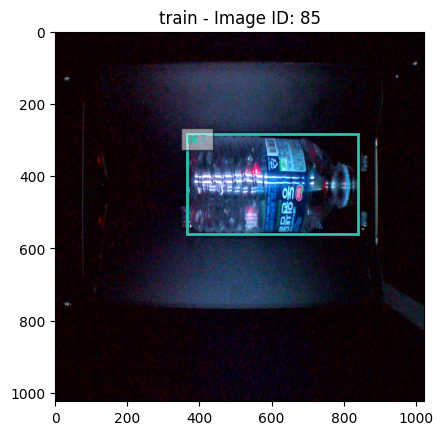

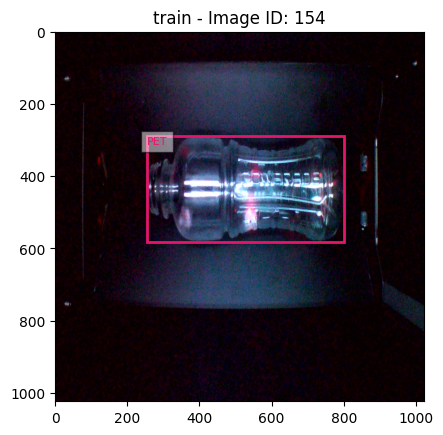

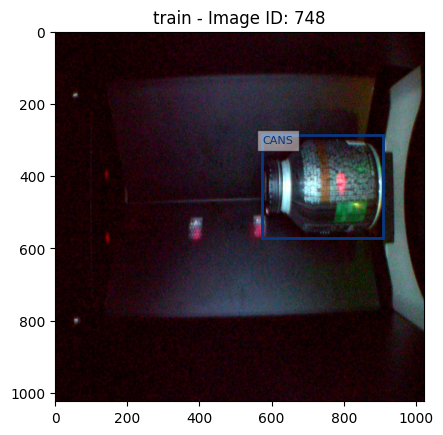

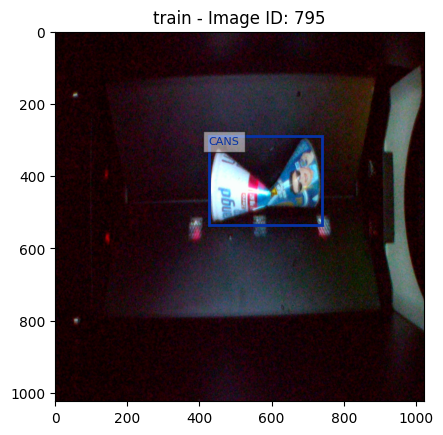

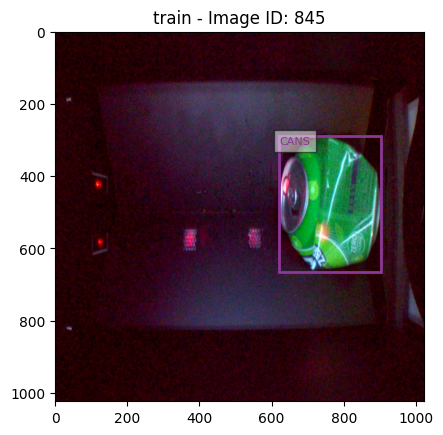

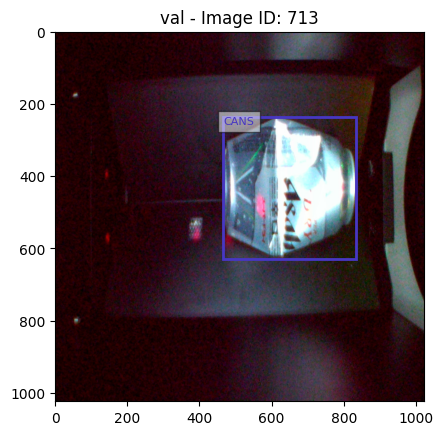

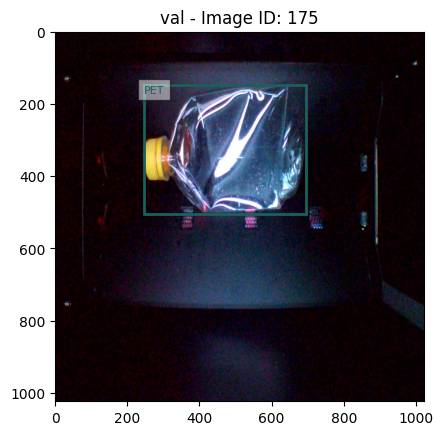

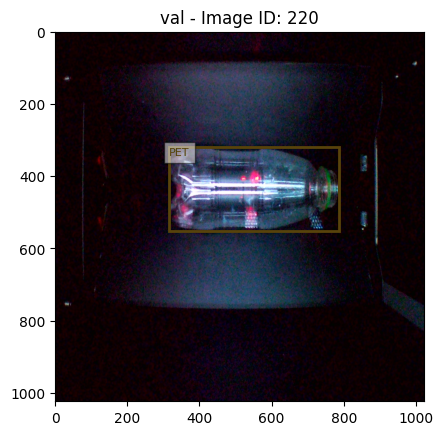

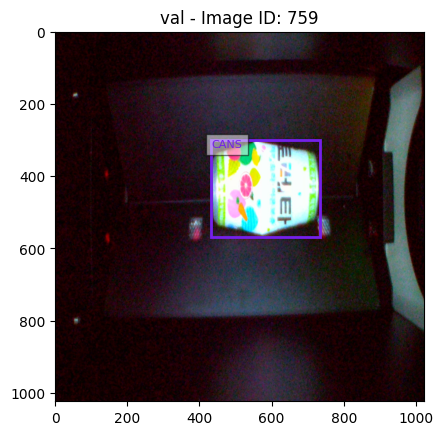

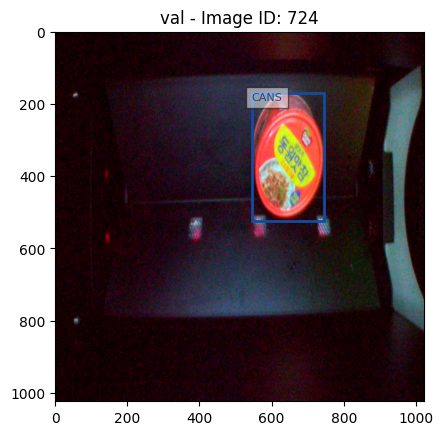

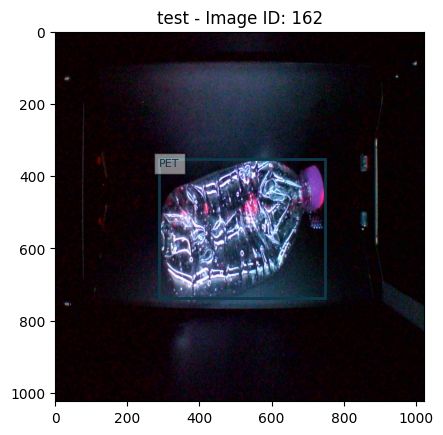

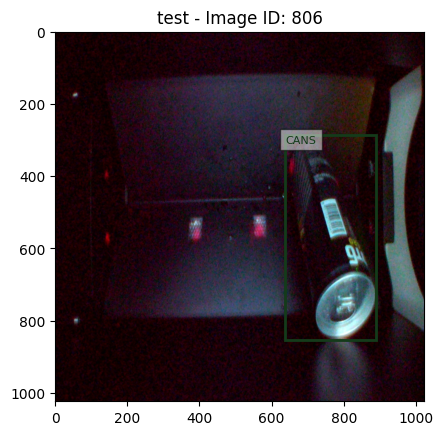

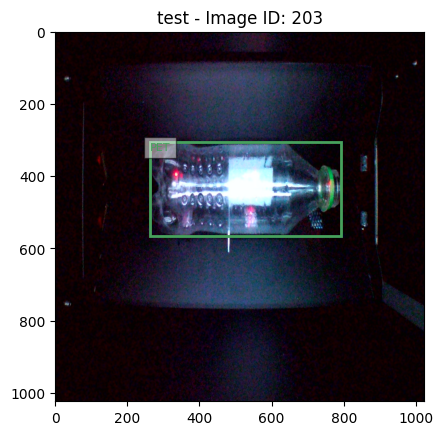

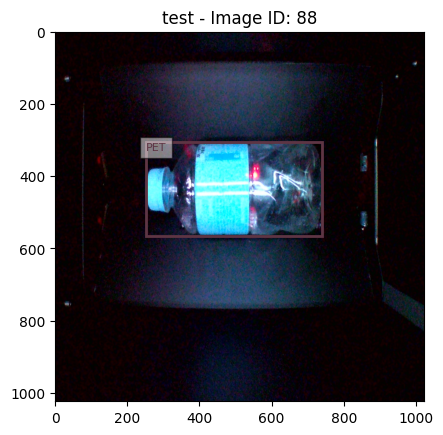

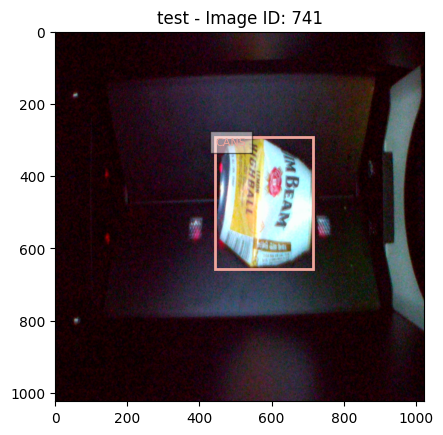

In [40]:
plot_coco_images(output_directory)

### Plot a single image

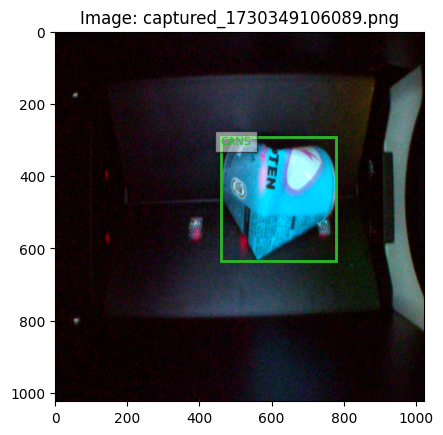

In [41]:
image_file_path = '.././rc40cocodataset_splitted/val/images/captured_1730349106089.png'


coco_annotation_file_path = '.././rc40cocodataset_splitted/val/coco_val.json' #replace with the path to the coco annotation file.

plot_single_coco_image(image_file_path, coco_annotation_file_path)